# Building Data Genome - Geographical Regions Load Profiles and Predictions



## Installations and Setting up

In [ ]:
#Installation

In [1]:
# Import required packages
import pandas as pd
import numpy as np
from google.colab import drive

# Visualization
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.pylab as pylab
%matplotlib inline
import seaborn as sns
sns.set_style("darkgrid")
mpl.style.use('ggplot')

import gc
import geopandas as gpd
from shapely.geometry import Point, Polygon

pd.set_option('display.max_colwidth', None)

In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!pwd

/content


In [4]:
!ls '/content/drive/MyDrive/Colab Notebooks/Energy Systems/data/'

chilledwater_cleaned.csv  hotwater_cleaned.csv	  solar_cleaned.csv  weather.csv
electricity_cleaned.csv   irrigation_cleaned.csv  steam_cleaned.csv
gas_cleaned.csv		  metadata.csv		  water_cleaned.csv


In [5]:
#Import csv data into dataframes
#Energy related
df_solar = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Energy Systems/data/solar_cleaned.csv')
df_water = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Energy Systems/data/water_cleaned.csv')
df_electricity = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Energy Systems/data/electricity_cleaned.csv')
df_gas = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Energy Systems/data/gas_cleaned.csv')
df_hotwater = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Energy Systems/data/hotwater_cleaned.csv')
df_irrigation = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Energy Systems/data/irrigation_cleaned.csv')
df_solar = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Energy Systems/data/solar_cleaned.csv')
df_steam = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Energy Systems/data/steam_cleaned.csv')

#Metadata
df_metadata = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Energy Systems/data/metadata.csv')

#Weather
df_weather = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Energy Systems/data/weather.csv')

## Description of the Metadata Dataset (as provided by the authors)



    building_id: building code-name with the structure SiteID_SimplifiedUsage_UniqueName.
    site_id: animal-code-name for the site.
    building_id_kaggle: building ID used for the Kaggle competition (numeric).
    site_id_kaggle: site ID used for the Kaggle competition (numeric).
    primaryspaceusage: Primary space usage of all buildings is mapped using the energystar scheme building description types.
    sub_primaryspaceusage: energystar scheme building description types subcategory.
    sqm: Floor area of building in square meters (m2).
    lat: Latitude of building location to city level.
    lng: Longitude of building location to city level.
    timezone: site's timezone.
    electricity: presence of this kind of meter in the building. Yes if affirmative, NaN if negative.
    hotwater: presence of this kind of meter in the building. Yes if affirmative, NaN if negative.
    chilledwater: presence of this kind of meter in the building. Yes if affirmative, NaN if negative.
    steam: presence of this kind of meter in the building. Yes if affirmative, NaN if negative.
    water: presence of this kind of meter in the building. Yes if affirmative, NaN if negative.
    irrigation: presence of this kind of meter in the building. Yes if affirmative, NaN if negative.
    solar: presence of this kind of meter in the building. Yes if affirmative, NaN if negative.
    gas: presence of this kind of meter in the building. Yes if affirmative, NaN if negative.
    industry: Industry type corresponding to building.
    subindustry: More detailed breakdown of Industry type corresponding to building.
    heatingtype: Type of heating in corresponding building.
    yearbuilt: Year corresponding to when building was first constructed, in the format YYYY.
    date_opened: Date building was opened for use, in the format D/M/YYYY.
    numberoffloors: Number of floors corresponding to building.
    occupants: Usual number of occupants in the building.
    energystarscore: Rating of building corresponding to building energystar scheme (Energy Star Score).
    eui: Energy use intensity of the building (kWh/year/m2).
    site_eui: Energy (Consumed/Purchased) use intensity of the site (kWh/year/m2).
    source_eui: Total primary energy consumption normalized by area (Takes into account conversion efficiency of primary energy into secondary energy).
    leed_level: LEED rating of the building (Leadership in Energy and Environmental Design), most widely used green building rating system.
    rating: Other building energy ratings.



## Mapping the buildings

In [ ]:
# Download the Natural Earth low-resolution data
!wget https://naturalearth.s3.amazonaws.com/110m_cultural/ne_110m_admin_0_countries.zip
!unzip ne_110m_admin_0_countries.zip

# Read the shapefile into a GeoDataFrame
world = gpd.read_file("ne_110m_admin_0_countries.shp")

# Exclude Antarctica and Fr. S. Antarctic Lands
world = world[(world.NAME != "Antarctica") & (world.NAME != "Fr. S. Antarctic Lands")]

# Coordinate reference system used in this map
world.crs

# All the sites
sites = df_metadata[["site_id","lat","lng"]].groupby("site_id").median()

# Converts lat and lng to geometry objects
geometry = [Point(xy) for xy in zip (sites["lng"], sites["lat"])]

# Creates geoDataFrame
geo_sites = gpd.GeoDataFrame(sites, crs = world.crs, geometry = geometry)

As can be seen below, we have buildings situated in very distinct geographical regions, with their own building regulations and weather conditions. We would like to know if there are some significant differences between them visible via time series analysis.

<Axes: >

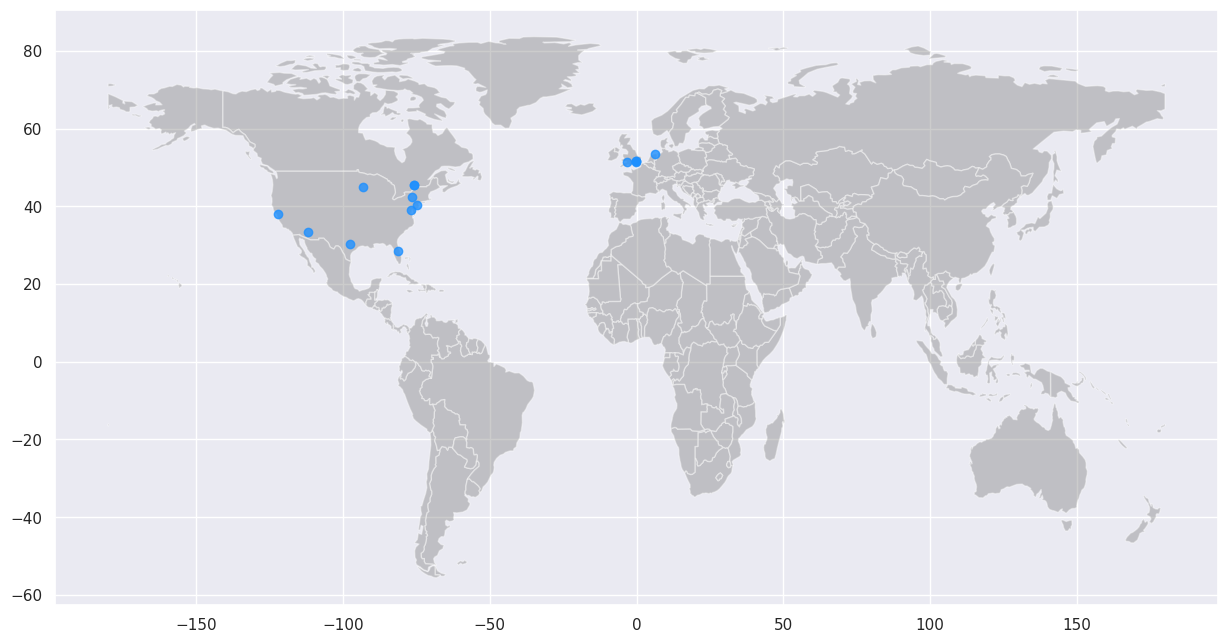

In [7]:
# Plot
sns.set(font_scale = 1)
fig, ax = plt.subplots(figsize = (15,15))
world.plot(ax = ax, alpha = 0.4, color = "grey")
geo_sites.plot(ax = ax, alpha = 0.8, color = "dodgerblue")

## Group by East Coast, West Coast and Europe

In [8]:
# Define bounding boxes for regions
east_coast_bbox = (-110, 25, -65, 46)  # (min_lon, min_lat, max_lon, max_lat)
west_coast_bbox = (-125, 32, -111, 49)
europe_bbox = (-10, 35, 30, 70)

In [9]:
#function to assign buildings to each region:
def assign_region(row):
    lon, lat = row['lng'], row['lat']
    if east_coast_bbox[0] <= lon <= east_coast_bbox[2] and east_coast_bbox[1] <= lat <= east_coast_bbox[3]:
        return 'East Coast'
    elif west_coast_bbox[0] <= lon <= west_coast_bbox[2] and west_coast_bbox[1] <= lat <= west_coast_bbox[3]:
        return 'West Coast'
    elif europe_bbox[0] <= lon <= europe_bbox[2] and europe_bbox[1] <= lat <= europe_bbox[3]:
        return 'Europe'
    else:
        return 'Other'

In [10]:
#Create a new column named "region" and populate it accordingly by applying the above-defined function:
df_metadata['region'] = df_metadata.apply(assign_region, axis=1)

In [11]:
df_metadata["region"].value_counts()

,count
region,
East Coast,919
Europe,251
Other,237
West Coast,229


All buildings with coordinates have been successfully classified:

In [12]:
len(df_metadata[(df_metadata["region"] == 'Other') & (df_metadata["lng"].notna()) & (df_metadata["lat"].notna())])

0

There are 237 buildings with no coordinates, which fall under the category "Other":

In [13]:
len(df_metadata[(df_metadata["region"] == 'Other') & (df_metadata["lng"].isna()) & (df_metadata["lat"].isna())])

237

We remove these buildings for the sake of this analysis:

In [15]:
# Remove buildings with region "Other":
df_metadata = df_metadata[df_metadata["region"] != 'Other']

Here we visualize the sites with the defined regions:

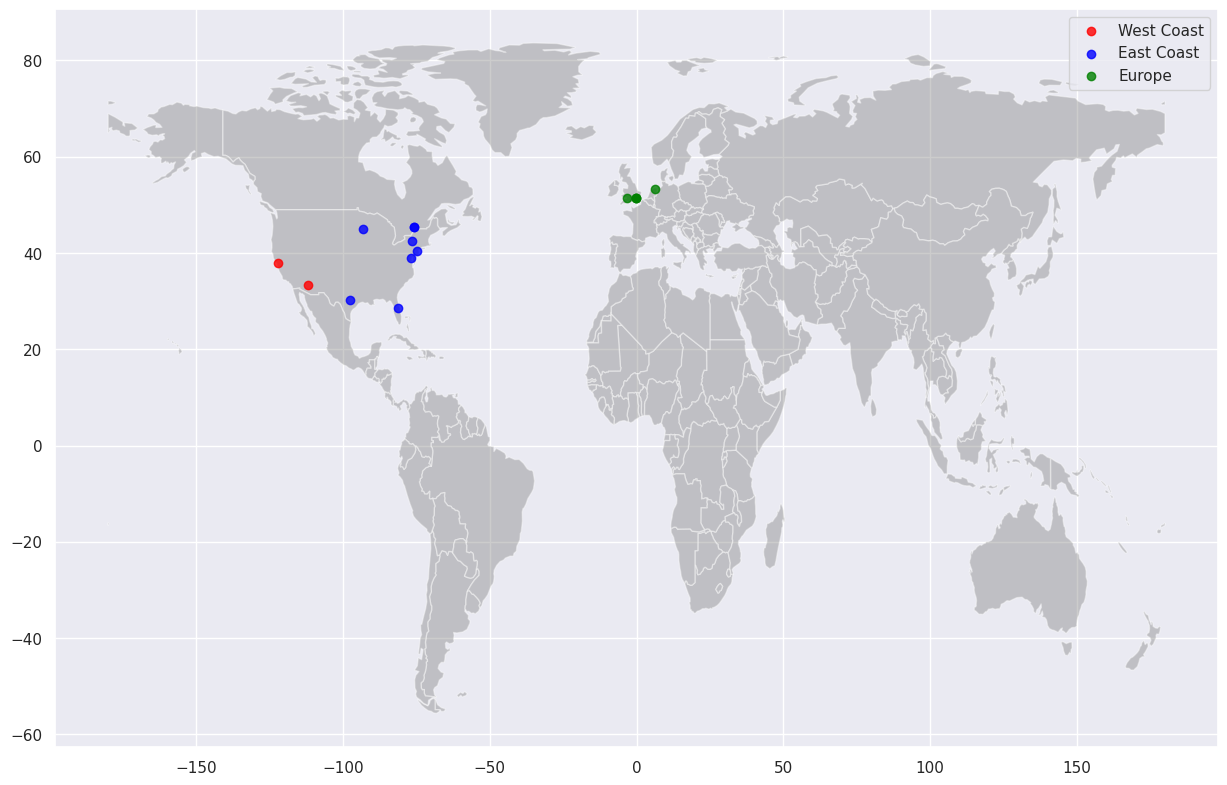

In [16]:
# All the sites
sites = df_metadata[["site_id","lat","lng", "region"]].groupby("site_id").agg({"lat": "median", "lng": "median", "region": "first"})

# Converts lat and lng to geometry objects
geometry = [Point(xy) for xy in zip (sites["lng"], sites["lat"])]

# Creates geoDataFrame
geo_sites = gpd.GeoDataFrame(sites, crs = world.crs, geometry = geometry)

# Define a dictionary to map regions to colors
region_colors = {
    'West Coast': 'red',
    'East Coast': 'blue',
    'Europe': 'green'
}

# Plot
sns.set(font_scale = 1)
fig, ax = plt.subplots(figsize = (15,15))
world.plot(ax = ax, alpha = 0.4, color = "grey")

# Plot sites with region-specific colors
for region, color in region_colors.items():
    geo_sites[geo_sites['region'] == region].plot(ax=ax, alpha=0.8, color=color, label=region)

# Add a legend
ax.legend()

plt.show()

## Merge the data

## Run the same features frequencies plots as in the authors' notebooks